# Using Machine Learning to analyse loan data!



**Daggy1234**

*Aspiring Data Scientist*


### Understanding the data set
------
The dataset is about past loans. The __loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


### The tools used to analyse the data set
----
Python has a rich plethora of machine learning and data analysis libraries we can choose from.
We use the following in this project.


In [503]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
# from sklearn.externals.six import StringIO
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
import pydotplus
from sklearn.linear_model import LogisticRegression
import matplotlib.image as mpimg
from sklearn import svm
from sklearn import tree
%matplotlib inline



In [504]:
#Opening the data and previewing it.

df = pd.read_csv('loan_train.csv')

#view the dimensions
print(f'Data frame dimensions: {df.shape}')
df.head()

Data frame dimensions: (346, 10)


,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [505]:
#We will now reformat the data into timestamps
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


###  Data visualisation to grasp and understand data
----
We will use libraries like seaborn and madplotlib to plot our data frame to understand it and get visual represenation.
We will make the comparison based on gender. and change the x axus to a different field.
* Based on principal
* age
* day of the week

In [506]:
#Lets begin by seeing the different categories of loan statuses and their counts
df['loan_status'].value_counts()


PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

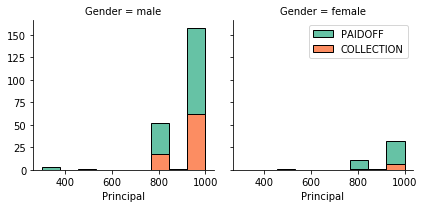

In [507]:
#principal
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()


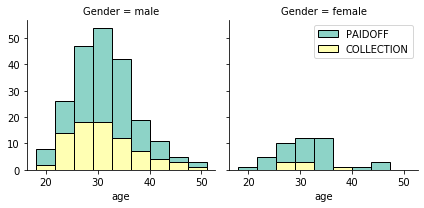

In [508]:
#age

bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set3", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()



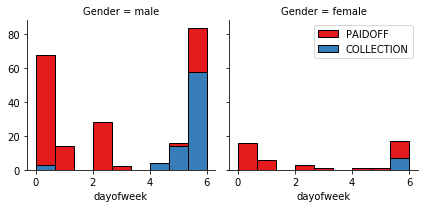

In [509]:
#based on day

df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

### Pre-processing:  Feature selection/extraction
----
We aim to convert most values to numerical values for easier processing!

`
We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4
`


In [510]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


In [511]:
#lets just process the data and see statistics based on gender and loan recovery.
print(df.groupby(['Gender'])['loan_status'].value_counts(normalize=True))

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64


86 % of female pay there loans while only 73 % of males pay their loan based on our data

`lets now normalise male and female into binary values. Male being 0 and females being 1`


In [512]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


#### After gender we now shift focus to Education level


In [513]:
# get loan status counts based on educational qualifications
print(df.groupby(['education'])['loan_status'].value_counts(normalize=True))
df[['Principal','terms','age','Gender','education']].head()




education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64


,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


`We will now turn most of these educational data fields into numerical values in a process called  One Hot Encoding
`

In [514]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection
----
we will now select the data set that we will split and use to train and evaluate the machine learning model



In [515]:
X = Feature
print(X[0:5])
y = df['loan_status'].values
y[0:5]

   Principal  terms  age  Gender  weekend  Bechalor  High School or Below  \
0       1000     30   45       0        0         0                     1   
1       1000     30   33       1        0         1                     0   
2       1000     15   27       0        0         0                     0   
3       1000     30   28       1        1         0                     0   
4       1000     30   29       0        1         0                     0   

   college  
0        0  
1        0  
2        1  
3        1  
4        1  


array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### Data Normalization and standardisation
---

Data Standardization give data zero mean and unit variance (technically should be done after train test split but why not)






In [516]:
X= preprocessing.StandardScaler().fit(X).transform(X)
#X[0:5]
print(X[0:5])

[[ 0.52  0.92  2.33 -0.42 -1.21 -0.38  1.14 -0.87]
 [ 0.52  0.92  0.34  2.38 -1.21  2.62 -0.88 -0.87]
 [ 0.52 -0.96 -0.65 -0.42 -1.21 -0.38 -0.88  1.15]
 [ 0.52  0.92 -0.49  2.38  0.83 -0.38 -0.88  1.15]
 [ 0.52  0.92 -0.32 -0.42  0.83 -0.38 -0.88  1.15]]


### Machine Learning Algorithms
---
We will now use multiple machine learning algorithms
to predict whether or not a case will result in a loan being paidoff or going to collection.

We will begin by splitting data into test set and train set


In [517]:
# split data set into training set and testing set
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)



Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


#### 1) K Nearest Neighbour Algorithim
We will try to find the best K to predict the values.

In [518]:
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):

    #Train Model and Predict
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)


    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67, 0.66, 0.71, 0.69, 0.76, 0.71, 0.79, 0.76, 0.76, 0.67, 0.7 ,
       0.73, 0.7 , 0.7 ])

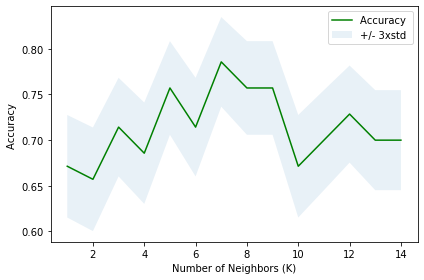

In [519]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [520]:
print("The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy was with 0.7857142857142857 with k= 7


##### We can conlude that the best value of k is **7**
This is the end of k knearest neighbours

#### 2) Decision Tree

In [521]:
loanTree = tree.DecisionTreeClassifier(criterion="entropy", max_depth = 4)
print(loanTree) # it shows the default parameters
loanTree.fit(X_train,y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4)


DecisionTreeClassifier(criterion='entropy', max_depth=4)

In [522]:
predTree = loanTree.predict(X_test)
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, predTree))
predTree

DecisionTrees's Accuracy:  0.6142857142857143


array(['COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF'], dtype=object)

In [523]:

# dot_data = StringIO()
# filename = "Loantree.png"
# featureNames = df.columns[0:8]
# targetNames = df["loan_status"].unique().tolist()
# out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
# graph.write_png(filename)
# img = mpimg.imread(filename)
# plt.figure(figsize=(100, 200))
# plt.imshow(img,interpolation='nearest')


#### 3) Support Vector Machine

In [524]:
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

In [525]:
yhat = clf.predict(X_test)
yhat [0:5]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70

Confusion matrix, without normalization
[[48  7]
 [11  4]]


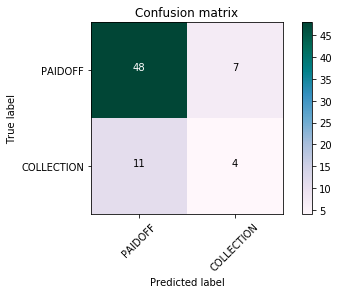

In [526]:
#we will now turn every Collect
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.inferno_r):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cnf_matrix = metrics.confusion_matrix(y_test, yhat, labels=["PAIDOFF","COLLECTION"])
np.set_printoptions(precision=2)

print (metrics.classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix',cmap=plt.cm.PuBuGn)

#### 4) Logisitic Regression

In [527]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = LR.predict(X_test)
yhat

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF'], dtype=object)

In [528]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob[0:5]

array([[0.5 , 0.5 ],
       [0.45, 0.55],
       [0.31, 0.69],
       [0.34, 0.66],
       [0.32, 0.68]])

Confusion matrix, without normalization
[[46  9]
 [13  2]]


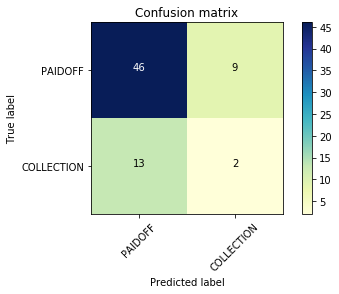

In [529]:
cnf_matrix = metrics.confusion_matrix(y_test, yhat,labels=["PAIDOFF","COLLECTION"])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=["PAIDOFF","COLLECTION"],normalize= False,  title='Confusion matrix',cmap=plt.cm.YlGnBu)

### Model Evaluation
---
We will now use a different data set similar to loan_train called loan_test to evaluate the model


In [530]:
#Create lists to store scores
algo = ['KNN','Decision Tree','SVM','LogisticRegression']
jaccardscores = []
fscores = []
logloss = []

In [531]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [532]:
#Process test data
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]
Y = test_df['loan_status'].values
Y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [533]:
k5 = 7
#Training the Model
neigh5 = KNeighborsClassifier(n_neighbors = k5).fit(X_train,y_train)
#Predict
yhatKNN = neigh5.predict(X_test)
yhatKNN=neigh.predict(X)
print(yhatKNN.shape)
print(y.shape)
print(yhatKNN[0:20])
KNNJaccard = jaccard_score(y, yhatKNN, pos_label="PAIDOFF")
KNNF1 = f1_score(y, yhatKNN, average='weighted')
print("Avg F1-score: " + str(round(KNNF1,2) ))
print("KNN Jaccard Score: " + str(round(KNNJaccard,2)))
jaccardscores.append(round(KNNJaccard,2))
fscores.append(round(KNNF1,2))
logloss.append(None)

(346,)
(346,)
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION'
 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF'
 'COLLECTION' 'PAIDOFF' 'PAIDOFF' 'COLLECTION' 'COLLECTION' 'COLLECTION']
Avg F1-score: 0.74
KNN Jaccard Score: 0.73


In [534]:
# Decision Tree
yhatDEC = loanTree.predict(X)
DTJaccard = jaccard_score(y, yhatDEC,pos_label="PAIDOFF")
DTF1 = f1_score(y, yhatDEC, average='weighted')
print("Avg F1-score: " + str(round(DTF1,2)) )
print("Decision Tree Jaccard Score: " + str(round(DTJaccard,2)))
jaccardscores.append(round(DTJaccard,2))
fscores.append(round(DTF1,2))
logloss.append(None)

Avg F1-score: 0.73
Decision Tree Jaccard Score: 0.67


In [535]:
# Support Vector Machine
yhatSVM=clf.predict(X)
SVMJaccard = jaccard_score(y, yhatSVM,pos_label="PAIDOFF")
SVMF1 = f1_score(y, yhatSVM, average='weighted')
print("Avg F1-score: " + str(round(SVMF1,2)))
print("SVM Jaccard score: " + str(round(SVMJaccard,2)))
jaccardscores.append(round(SVMF1,2))
fscores.append(round(SVMJaccard,2))
logloss.append(None)

Avg F1-score: 0.76
SVM Jaccard score: 0.75


In [536]:
print(yhat.shape)
print(y_test.shape)
lrjaccard = round(jaccard_score(y_test,yhat,pos_label="PAIDOFF"),2)
lrlogloss = round(log_loss(y_test, yhat_prob),2)
print(f"LOG Jaccard score: {lrjaccard}")
print (f"Log Loss Regressions: {lrlogloss}")
LogRF1 = round(f1_score(y_test, yhat, average='weighted'),2)
print(f"Avg F1-score: {LogRF1}")
jaccardscores.append(lrjaccard)
fscores.append(LogRF1)
logloss.append(lrlogloss)

(70,)
(70,)
LOG Jaccard score: 0.68
Log Loss Regressions: 0.58
Avg F1-score: 0.67


`After calculating all the metrics lets now cast all the data to a dataframe!`

In [537]:
rf = pd.DataFrame({'algorithim':algo,'Jaccard':jaccardscores,'F1-Score':fscores,'LogLoss':logloss})
rf.head()


,algorithim,Jaccard,F1-Score,LogLoss
0,KNN,0.73,0.74,NaN
1,Decision Tree,0.67,0.73,NaN
2,SVM,0.76,0.75,NaN
3,LogisticRegression,0.68,0.67,0.58


In [546]:
#lets just get the data by taking the mean o

rf.mean(axis=1)

0    0.735000
1    0.700000
2    0.755000
3    0.643333
dtype: float64

Based on this we can conclude the best machine learning technique with the best ,metrics is SVM or support vector machines . Behind it is KKN.

We can also conclude that by supplying the data we can predict with almost 75% certainty wether a person will default on a loan.


### Credits
-----
I would like to thank all the instructors of this course including
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

I would also like to thank IBM for supplying the data!
Special thanks to me for finishing this course.
